In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import random
import re
import math
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
import scipy
from scipy import optimize
import scipy.stats
import datashader as ds
import colorcet
import keras
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.
/home/philippe/src/temp/load-shifting-potential/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/philippe/src/temp/load-shifting-potential/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/philippe/src/temp/load-shifting-potential/.venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 =

In [2]:
def centered_moving_sum(a, n) :
    return np.convolve(a, np.ones(n, dtype=int), 'full')[(n // 2):]

In [3]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

# Load the data

In [4]:
data_dir = os.path.abspath('../../data/published_data_vs01/data')
data_filenames = ['dfA_300s.hdf', 'dfD_300s.hdf', 'dfE_300s.hdf']

In [5]:
input_arrays = []
for filename in data_filenames:
    df = pd.read_hdf(os.path.join(data_dir, filename))
    
    column_mapping = {}
    for c in df.columns:
        if c in column_mapping:
            continue
        m = re.match(r'^[A-Z]_(\w+)$', c)
        if m is None:
            raise RuntimeError('Unsupported column name format {}. You will have to map the column manually.'.format(c))
        column_mapping[c] = m[1]
    df.rename(columns=column_mapping, inplace=True)
    
    all_appliance_columns = sorted({'dishwasher_power', 'washing_machine_power', 'tumble_dryer_power'} & set(df.columns))
    for c in all_appliance_columns:
        input_arrays.append(df[c].to_numpy())

In [6]:
input_arrays = [a[~np.isnan(a)] for a in input_arrays]

In [7]:
[len(a) for a in input_arrays]

[166147, 166147, 296666, 286900, 273043, 273815, 273814, 273713]

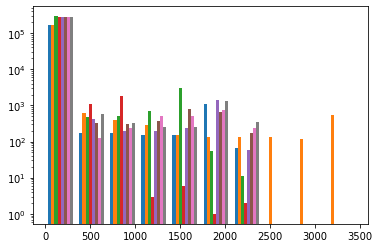

In [8]:
plt.hist(input_arrays, log=True, bins=10)
plt.show()

# Experiment with one appliance

## Find very rough active areas
These areas are detected very convervatively. In these areas the appliance may be on. Outside of these areas it is very unlikely to be on.

In [9]:
# If no significant power is drawn for this many periods, the appliance is assumed to be off
safe_pause = 24

# The appliance is assumed to be on less than this ratio of the time
safe_covered_ratio = 0.5

In [10]:
chosen_input_array = random.choice(input_arrays)
len(chosen_input_array)

296666

In [11]:
def detect_activity(input_array, window_size = safe_pause, greater_than=0):
    return centered_moving_sum(input_array > greater_than, window_size) > 0

In [12]:
detected_mask = detect_activity(chosen_input_array)
print("Mask covers {:.2f}% of samples".format(100 * np.sum(detected_mask) / len(detected_mask)))

Mask covers 14.79% of samples


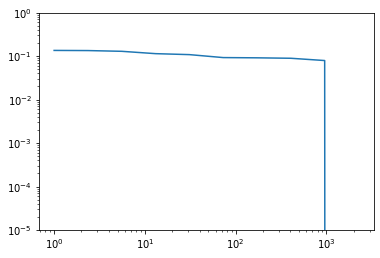

In [13]:
thresholds = np.logspace(0, math.log10(chosen_input_array.max()), num=10)
covered_ratio = np.array(list(
    detect_activity(chosen_input_array, greater_than=x).sum() / len(chosen_input_array)
    for x in thresholds
))
plt.yscale('log')
plt.gca().set_ylim([0.00001, 1])
plt.xscale('log')
plt.plot(thresholds, covered_ratio);

In [14]:
covered_ratio

array([0.13469356, 0.13367221, 0.12850141, 0.11350812, 0.10783844,
       0.09218448, 0.09105189, 0.08890469, 0.07882939, 0.        ])

In [15]:
i = np.argmax(covered_ratio < safe_covered_ratio)
very_low_noise_threshold = thresholds[i]
print("very_low_noise_threshold is {:.2g} (at index {}; covering {:.2f}%)".format(
    very_low_noise_threshold, i, 100 * covered_ratio[i],
))

very_low_noise_threshold is 1 (at index 0; covering 13.47%)


In [16]:
detected_mask = detect_activity(chosen_input_array, greater_than=very_low_noise_threshold)
print("Mask covers {:.2f}% of samples".format(100 * np.sum(detected_mask) / len(detected_mask)))

Mask covers 13.47% of samples


In [17]:
def active_areas_from_detected(detected_mask):
    detected_mask = np.append(np.insert(detected_mask, 0, False), False)
    temp = np.diff(detected_mask.astype('int8'))
    starts = np.argwhere(temp == 1)
    ends = np.argwhere(temp == -1)
    l = min(len(starts), len(ends))
    return np.hstack((starts[:l], ends[:l]))

In [18]:
active_areas = active_areas_from_detected(detected_mask)
print(len(active_areas))
active_areas[np.random.choice(active_areas.shape[0], 3, replace=False)]

699


array([[146783, 146839],
       [235046, 235102],
       [231295, 231351]])

In [19]:
active_area_data = [chosen_input_array[a[0]:a[1]] for a in active_areas]

## Detect outliers

In [20]:
# The max power used by the appliance in the initial active areas, filtered by this percentile,
# is assumed to be roughly the max power used by the appliance
rough_max_power_percentile = 95

# Any initial active area where the max power used is less than
# this ratio of the rough max power of the appliance is ignored
too_low_power_ratio = 0.02

In [21]:
len_max_coords = np.column_stack(([len(a) for a in active_area_data], [a.max() for a in active_area_data]))
lof_labels = LocalOutlierFactor().fit_predict(len_max_coords)

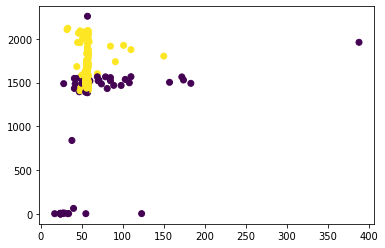

In [22]:
colors = np.array(['r.', 'g.', 'b.'])
plt.scatter(len_max_coords[:, 0], len_max_coords[:, 1], c=lof_labels);

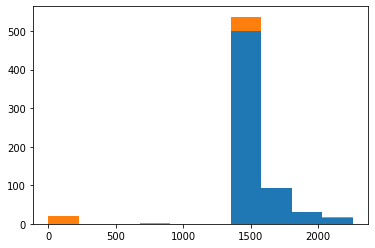

In [23]:
plt.hist([len_max_coords[lof_labels == l][:, 1] for l in [1, -1]], stacked=True);

In [24]:
rough_max_power = np.percentile(len_max_coords[:, 1], 95)
too_low_power = rough_max_power * too_low_power_ratio
print(rough_max_power, too_low_power)

1874.0951999999997 37.48190399999999


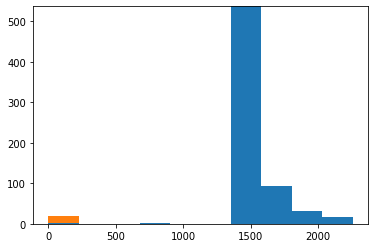

In [25]:
too_low_power_mask = len_max_coords[:, 1] < too_low_power
plt.hist([len_max_coords[too_low_power_mask == l][:, 1] for l in [False, True]], stacked=True);

Using 91.70% of initial active areas


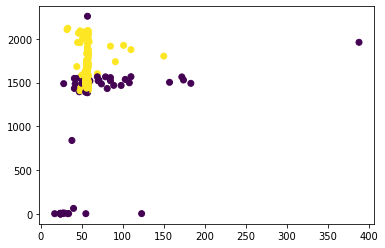

In [26]:
initial_active_area_mask = ~too_low_power_mask & (lof_labels == 1)
print("Using {:.2f}% of initial active areas".format(
    100 * initial_active_area_mask.sum() / len(active_areas)))
plt.scatter(len_max_coords[:, 0], len_max_coords[:, 1], c=initial_active_area_mask);

## Filter outliers

In [27]:
filtered_active_area_data, ignored_active_area_data = ([a for a, mask in zip(active_area_data, initial_active_area_mask) if mask == use] for use in [True, False])
print("Using {} active areas ({} ignored)".format(len(filtered_active_area_data), len(ignored_active_area_data)))

Using 641 active areas (58 ignored)


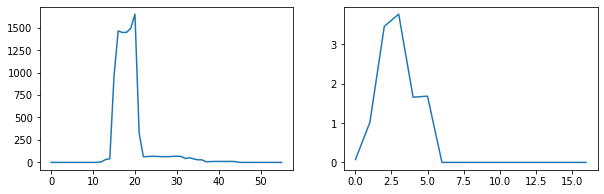

In [28]:
_, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(random.choice(filtered_active_area_data))
axes[1].plot(random.choice(ignored_active_area_data));

## Align active areas

In [29]:
# Active areas will be aligned so that their first samples where
# power is above this level line up.
# The level is specified as a ratio of the peak power of each active area.
alignment_min_energy_ratio = 0.5

In [30]:
alignment_offsets = np.array([
    np.argwhere(samples >= alignment_min_energy_ratio * samples.max())[0][0]
    for samples in filtered_active_area_data
])
alignment_target = alignment_offsets.max()
alignment_offsets = alignment_target - alignment_offsets
aligned_length = max(
    alignment_offsets[i] + len(samples)
    for i, samples in enumerate(filtered_active_area_data)
)

print("Aligning to index {} for padded length of {}".format(alignment_target, aligned_length))

Aligning to index 30 for padded length of 165


In [31]:
aligned_active_area_data = np.stack([
    np.pad(samples, ((offset, aligned_length - len(samples) - offset)))
    for offset, samples in zip(alignment_offsets, filtered_active_area_data)
])
aligned_active_area_data.shape

(641, 165)

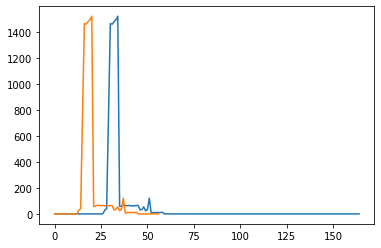

In [32]:
i = random.randrange(len(aligned_active_area_data))
plt.subplot()
plt.plot(aligned_active_area_data[i])
plt.plot(filtered_active_area_data[i]);

## Vizualize curves

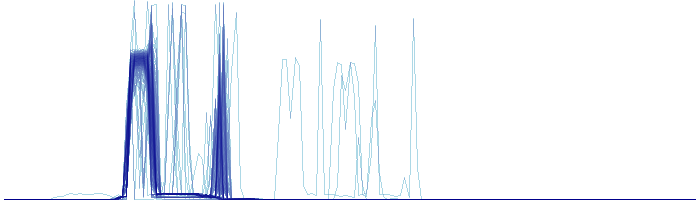

In [33]:
parts = []
separator = pd.DataFrame({ 'x': [np.nan], 'y': [np.nan] })
for array in aligned_active_area_data:
    part = pd.DataFrame({ 'y': array })
    part['x'] = part.index
    parts.append(part)
    parts.append(separator)
temp = pd.concat(parts, ignore_index=True)
del parts

x_max = max(len(a) for a in aligned_active_area_data)
cvs = ds.Canvas(x_range=[-1, x_max], y_range=[0, temp.y.max()], plot_width=700, plot_height=200)
agg = cvs.line(temp, 'x', 'y', ds.count())
out = ds.transfer_functions.shade(agg)
out

## Synthesize active areas with multiple runs

In [34]:
# When shifting a sequence to synthesize active areas with multiple runs,
# keep at least this ratio of the total energy. Any remaining energy may
# be lost because the sequence is shifted out of range.
synthesize_multi_max_offset_energy_ratio = 0.99

# This determines the proportion of runs with different multiples which are used for training. 
# copy_weights[i] determines the proportion of synthesized runs with i-multiples
# copy_weights[0] must be 1, since all true (non-multiplied) active areas are always included
copy_weights = [1, 1]

# The maximum number of attempts used by multiply_runs_no_overlap to synthesize a valid sequence
no_overlap_max_iterations = 10

In [35]:
max_power = aligned_active_area_data.max()

In [36]:
def multiply_runs(base_true_samples, overlay_true_samples_list):
    multiplied_samples = base_true_samples.copy()
    for overlay_true_samples in overlay_true_samples_list:
        max_offset = np.argwhere(
            np.cumsum(overlay_true_samples) >=
            overlay_true_samples.sum() * synthesize_multi_max_offset_energy_ratio
        )[0][0]
        offset = random.randrange(max_offset - 1) + 1
        
        shifted_samples = np.zeros_like(overlay_true_samples)
        shifted_samples[offset:] = overlay_true_samples[:-offset]
        
        multiplied_samples += shifted_samples
        
    return multiplied_samples

def multiply_runs_no_overlap(base_true_samples, overlay_true_samples_list, max_iterations=no_overlap_max_iterations):
    for i in range(no_overlap_max_iterations):
        multiplied_samples = multiply_runs(base_true_samples, overlay_true_samples_list)
        if multiplied_samples.max() <= base_true_samples.max():
            return multiplied_samples
    return None

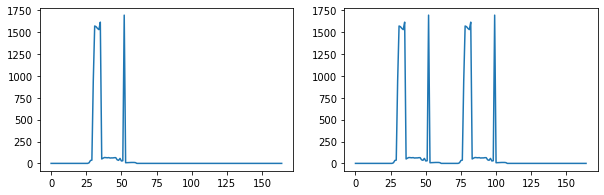

In [37]:
true_samples = random.choice(aligned_active_area_data)
multiplied_samples = multiply_runs_no_overlap(true_samples, [true_samples], max_iterations=100)

_, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(true_samples)
axes[1].plot(multiplied_samples);

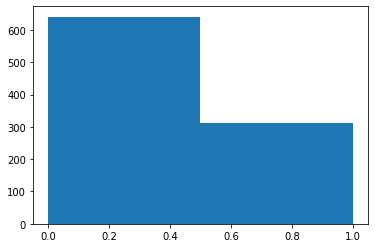

In [38]:
temp = list(aligned_active_area_data)
multiplied_parts = [
    (i, multiply_runs_no_overlap(a, random.sample(temp, i)))
    for i, w in enumerate(copy_weights)
    for a in random.sample(temp, round(len(temp) * w))
]
multiplied_parts = [(i, a) for i, a in multiplied_parts if a is not None]

plt.hist([i for i, a in multiplied_parts], bins=len(copy_weights));

## Prepare features

In [39]:
# Features
# - y-scaled(0, 1) data

def samples_to_features(samples):
    return (samples / max_power).astype('float32')

def features_to_samples(features):
    return features * max_power

parts = []
for _, samples in multiplied_parts:
    parts.append(samples_to_features(samples))
    
X = np.stack(parts)
y = np.array(keras.utils.to_categorical([i for i, _ in multiplied_parts]))
del parts

print(X.shape, y.shape)

(953, 165) (953, 2)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

## Train a classifier
The number of synthetic runs (copies) in an active area are used as its class.

In [41]:
copy_classifier = keras.models.Sequential([
    keras.layers.Reshape((-1, 1), input_shape=(X.shape[1],)),
    keras.layers.Conv1D(filters=2, kernel_size=10, padding='same'),
    keras.layers.Reshape((-1,)),
    keras.layers.Dense(8),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(y.shape[1]),
    keras.layers.Activation('softmax'),
])

In [42]:
copy_classifier.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

copy_classifier.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    shuffle=True,
    epochs=100,
    verbose=0,
    callbacks=[TQDMNotebookCallback(leave_inner=True)]
)

0 0 [[9.9998140e-01 1.8549023e-05]]


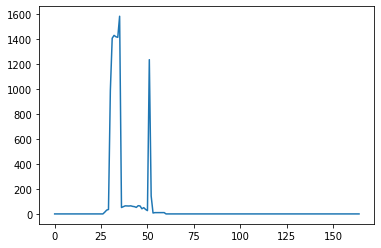

In [43]:
temp = random.choice(list(zip(X, y)))
multiplied_samples = features_to_samples(temp[0])
i = np.argmax(temp[1])

temp = copy_classifier.predict(temp[0].reshape((1, -1)))
print(i, np.argmax(temp), temp)

plt.plot(multiplied_samples);

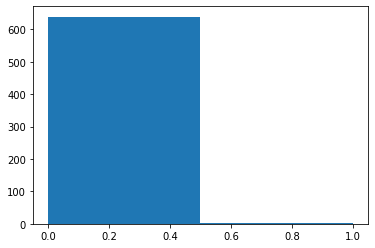

In [44]:
predictions = copy_classifier.predict(np.stack([
    samples_to_features(a) for a in aligned_active_area_data
]))
plt.hist(predictions.argmax(axis=1), bins=y.shape[1]);

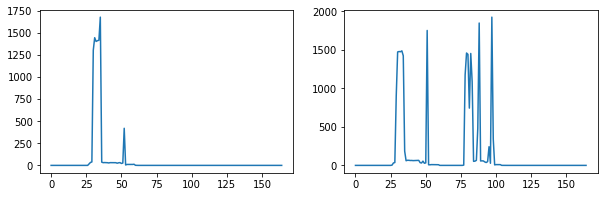

In [45]:
_, axes = plt.subplots(1, 2, figsize=(10, 3))
for i, f in enumerate([lambda x: x == 0, lambda x: x > 0]):
    j = random.choice(np.argwhere(f(predictions.argmax(axis=1))))[0]
    axes[i].plot(aligned_active_area_data[j])

In [46]:
probably_single_run_mask = predictions.argmax(axis=1) == 0

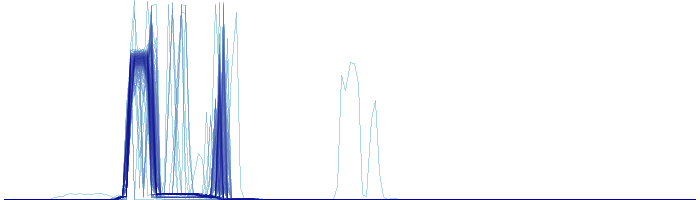

In [47]:
parts = []
separator = pd.DataFrame({ 'x': [np.nan], 'y': [np.nan] })
for array in aligned_active_area_data[probably_single_run_mask]:
    part = pd.DataFrame({ 'y': array })
    part['x'] = part.index
    parts.append(part)
    parts.append(separator)
temp = pd.concat(parts, ignore_index=True)
del parts

x_max = max(len(a) for a in aligned_active_area_data)
cvs = ds.Canvas(x_range=[-1, x_max], y_range=[0, temp.y.max()], plot_width=700, plot_height=200)
agg = cvs.line(temp, 'x', 'y', ds.count())
out = ds.transfer_functions.shade(agg)
out

## Preparing data for start detection

In [48]:
# Similar to (1 - synthesize_multi_max_offset_energy_ratio), but used
# for detecting starts and ends points in an active area
# to provide initial labels for training start/end detection
start_end_index_energy_ratio = 0.01

window_len_factor = 3

In [49]:
def estimate_start_end_indices(samples):
    start_index = np.argwhere(
        np.cumsum(samples) <=
        samples.sum() * start_end_index_energy_ratio
    )[-1][0]
    end_index = np.argwhere(
        np.cumsum(samples) >=
        samples.sum() * (1 - start_end_index_energy_ratio)
    )[0][0] + 1
    return start_index, end_index

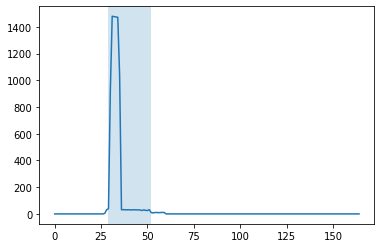

In [50]:
samples = random.choice(aligned_active_area_data[probably_single_run_mask])

start_end_indices = estimate_start_end_indices(samples)

plt.plot(samples)
plt.axvspan(start_end_indices[0], start_end_indices[1], alpha=0.2);

In [51]:
start_end_indices_for_single_runs = [
    estimate_start_end_indices(samples)
    for samples in aligned_active_area_data[probably_single_run_mask]
]
temp = np.array([end - start for start, end in start_end_indices_for_single_runs])
median_start_end_len = int(round(np.median(temp)))
median_start_end_len

23

In [52]:
window_len = median_start_end_len * window_len_factor
center = window_len // 2
marker_stddev = max(median_start_end_len / 8, 1)

In [53]:
def add_shifted_arrays(parts, output_length):
    out = np.zeros(output_length)
    for offset, array in parts:
        a = max(offset, 0)
        b = min(offset + len(array), output_length)
        out[a:b] = out[a:b] + array[a-offset:b-offset]
    return out

y_start: 0.00
y_end: 0.00


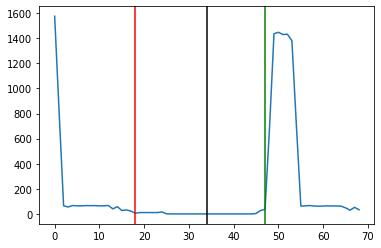

In [54]:
def fill_window_with_random_data():
    pool = aligned_active_area_data[probably_single_run_mask]
    
    scale = random.uniform(0, 1)
    
    starts = []
    ends = []
    parts = []
    i = None
    while i is None or i < window_len:
        j = random.randrange(len(pool))
        samples = pool[j]
        start_end_indices = start_end_indices_for_single_runs[j]
        samples_len = start_end_indices[1] - start_end_indices[0]
        
        if i is None:
            i = random.randrange(-samples_len, round(window_len * scale))
            
        parts.append((i - start_end_indices[0], samples))
        starts.append(i)
        i += samples_len
        ends.append(i)
        
        # TODO This is total guesswork, but the results seem kind of acceptable
        temp = window_len if np.random.rand() < 0.8 else 2
        i += int(round(np.random.exponential(1 / (3 / 2)) * temp))
        if np.random.rand() < 0.5:
            i -= 1
    
    return add_shifted_arrays(parts, window_len), np.array(starts), np.array(ends)

def markers_to_y_label(markers, mean = center, stddev = marker_stddev):
    norm = scipy.stats.norm(mean, stddev)
    return norm.pdf(markers).sum() / norm.pdf(center)

temp, starts, ends = fill_window_with_random_data()
plt.plot(temp)
for i in starts:
    if i >= 0:
        plt.axvline(i, color='green')
for i in ends:
    if i < len(temp):
        plt.axvline(i, color='red')
plt.axvline(center, color='black');
print("y_start: {:.2f}".format(markers_to_y_label(starts)))
print("y_end: {:.2f}".format(markers_to_y_label(ends)))

In [55]:
def samples_to_features(samples):
    return (samples / max_power).astype('float32')

norm = scipy.stats.norm(0, 5)

X = []
y = []
for i in range(30000):
    samples, starts, ends = fill_window_with_random_data()
    X.append(samples_to_features(samples))
    y.append([markers_to_y_label(m) for m in [starts, ends]])
    
X = np.stack(X)
y = np.array(y)

print(X.shape, y.shape)

(30000, 69) (30000, 2)


y = (0.0007, 0.0000)


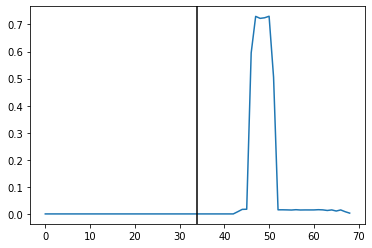

In [56]:
i = random.randrange(len(X))
print("y = ({:.4f}, {:.4f})".format(y[i][0], y[i][1]))
plt.plot(X[i])
plt.axvline(center, color='black');

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

In [58]:
start_classifier = keras.models.Sequential([
    keras.layers.Reshape((X.shape[1], 1), input_shape=(X.shape[1],)),
    keras.layers.Bidirectional(keras.layers.LSTM(20, unroll=True)),
    keras.layers.Reshape((-1,)),
    keras.layers.Dense(y.shape[1]),
    keras.layers.Activation('sigmoid'),
    # keras.layers.Dense(1),
    # keras.layers.Activation('softmax'),
])

In [59]:
start_classifier.compile(optimizer='adam', loss='mse')

start_classifier.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    shuffle=True,
    epochs=30,
    batch_size=128,
    verbose=0,
    callbacks=[TQDMNotebookCallback(leave_inner=True)]
)

y_true = (0.0000, 0.0000), y_pred = (0.0023, 0.0056)


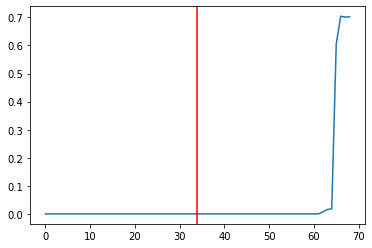

In [60]:
i = random.randrange(len(X))
y_true = y[i]
y_pred = start_classifier.predict(np.stack([X[i]]))[0]

print("y_true = ({:.4f}, {:.4f}), y_pred = ({:.4f}, {:.4f})".format(y_true[0], y_true[1], y_pred[0], y_pred[1]))
plt.plot(X[i])
plt.axvline(center, color='red');

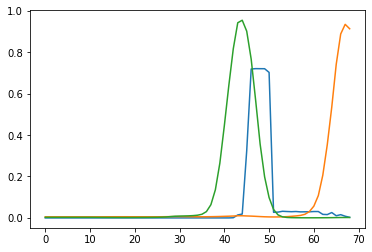

In [61]:
original_sequence = random.choice(X_test)

min_offset = -center
max_offset = len(original_sequence) - center

shifted_sequences = []
index_of_pred_for_0 = None
for j, offset in enumerate(range(min_offset, max_offset + 1)):
    if center - offset == 0:
        index_of_pred_for_0 = j
    
    shifted_sequence = np.roll(original_sequence, offset)
    if offset >= 0:
        shifted_sequence[:offset] = np.zeros(offset)
    else:
        shifted_sequence[offset:] = np.zeros(-offset)
    shifted_sequences.append(shifted_sequence)
shifted_sequences = np.stack(shifted_sequences)

y_pred = start_classifier.predict(np.stack(shifted_sequences))
y_pred = np.flip(y_pred[:(index_of_pred_for_0 + 1)])[:len(original_sequence)]
plt.plot(original_sequence)
plt.plot(y_pred);

## Slice data with start classifier

In [62]:
def determine_peak_positions(data, threshold=0.5):
    parts = np.split(data, np.where(np.diff(data >= threshold))[0] + 1)
    
    peak_positions = []
    j = 0
    for p in parts:
        if p.max() >= threshold:
            peak_positions.append(j + p.argmax())
        j += len(p)
    
    return peak_positions

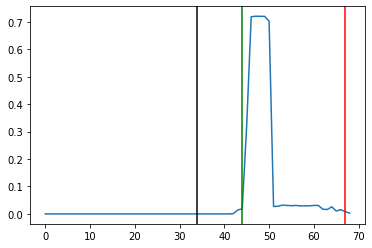

In [63]:
starts = determine_peak_positions(y_pred[:, 1])
ends = determine_peak_positions(y_pred[:, 0])

plt.plot(original_sequence)
for i in starts:
    if i >= 0:
        plt.axvline(i, color='green')
for i in ends:
    if i < len(original_sequence):
        plt.axvline(i, color='red')
plt.axvline(center, color='black');

In [64]:
def sliding_apply_start_classifier(samples):
    out = np.full((len(samples), y.shape[1]), np.nan)
    if len(samples) < window_len:
        return out
    
    features = samples_to_features(samples)
    out[center:(len(samples) - window_len + center + 1)] = start_classifier.predict(np.stack([
        features[i:i+window_len]
        for i in range(len(samples) - window_len + 1)
    ]))
    
    return out

In [65]:
samples = chosen_input_array
y_pred = sliding_apply_start_classifier(samples)

In [66]:
starts = determine_peak_positions(y_pred[:, 0])
ends = determine_peak_positions(y_pred[:, 1])

In [67]:
intervals = []
i_s = 0
i_e = 0
while i_s < len(starts) and i_e < len(ends):
    s, e = starts[i_s], ends[i_e]
    if e <= s:
        i_e += 1
        continue
    if e - s > window_len:
        i_s += 1
        continue
    intervals.append((s, e))
    i_s += 1
    i_e += 1
intervals = np.array(intervals)

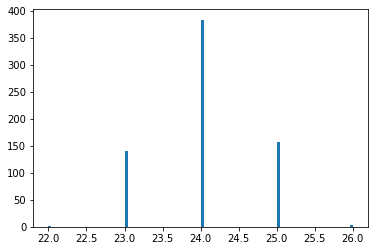

In [68]:
plt.hist(np.diff(intervals, axis=1), bins=100);

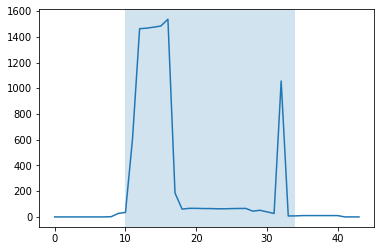

In [100]:
padding = 10
interval = random.choice(intervals)
samples = chosen_input_array[(interval[0] - padding):(interval[1] + padding)]

plt.plot(samples)
plt.axvspan(padding, interval[1] - interval[0] + padding, alpha=0.2)